# 导入依赖库和转换数据格式
主要依赖库：
1. numpy 用于矩阵运算
2. pandas 用于表格处理
3. pathlib 主要用于文件路径处理
4. sklearn 用于机器学习算法，这里主要使用了线性回归LinearRegression

安装第三方库：你可以选择本地已经配置好的的conda环境，或者创建新的虚拟环境来安装，例如


`conda env list` # 查看已有环境

`conda create -n abm python=3.9` # 创建新的环境

`conda activate abm` # 激活环境

`pip install numpy pandas scikit-learn matplotlib seaborn` # 安装第三方库



In [2]:
!pip install numpy pandas scikit-learn matplotlib seaborn

In [3]:
import math
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LinearRegression

这里我们做了几件事：
1. 合并市场数据的日期和时间，便于利用pandas高效的时间序列处理能力（例如我们能直接用大小于号取一段时间序列）
2. 处理市场数据以符合最终的提交格式，保存到本地便于后续直接使用

`submit.csv`提交格式
```csv
day,time,clearing price （CNY/MWh）
2024/4/1 , 0:15 , 352.334 
2024/4/1 , 0:30 , 355.536
```

3. 设置市场数据的列顺序，并去除合并前的时间列

**在进行进一步编写代码前，有效的预处理能大量减少后续迭代方案的耗时**

In [9]:

base_path = Path("data")  # 确保数据都放在同级的data目录下

# 读取市场数据
electricity_price = pd.read_csv(base_path / "electricity price.csv")
# 读取市场主体（各发电机组）数据
unit = pd.read_csv(base_path / "unit.csv")

"""
准备示例提交数据sample_submit
1. electricity_price["clearing price (CNY/MWh)"].isna()找到出清价格为缺失值的行，即要预测的目标
2. 去除demand列，符合最后的提交格式 
"""


#对于出清价格一列创建布尔掩码
nan_mask=electricity_price['clearing price (CNY/MWh)'].isna()

#创建新的DataFrame，只包含出清价格为NaN值的行，且删除了demand列，不包含索引（当index参数为False时）
sample_submit = electricity_price[nan_mask].drop(columns="demand")
sample_submit.to_csv(base_path / "sample_submit.csv", index=False)

print(len(electricity_price))
print(len(sample_submit))

# 使用布尔索引获取这些NaN值所在的行索引
nan_row_indices = electricity_price[nan_mask].index
print(nan_row_indices)  # 输出包含NaN值的行的索引

#当index=True，发现出清价格为空的行是倒数28128行，因此可以将前55392行作为训练集，后28128行作为测试集。

print(electricity_price.columns)


83520
28128
Index([55392, 55393, 55394, 55395, 55396, 55397, 55398, 55399, 55400, 55401,
       ...
       83510, 83511, 83512, 83513, 83514, 83515, 83516, 83517, 83518, 83519],
      dtype='int64', length=28128)
Index(['day', 'time', 'demand', 'clearing price (CNY/MWh)'], dtype='object')


In [10]:
# 将day和time列合并成timestamp列，便于提取时间戳特征
electricity_price["timestamp"] = pd.to_datetime(
    electricity_price["day"] + " " + electricity_price["time"].str.replace("24:00:00", "00:00"))

# 处理24:00:00的情况，即表示第二天的00:00:00
mask = electricity_price['timestamp'].dt.time == pd.Timestamp('00:00:00').time()

# 需要将这些行的日期部分加一天
electricity_price.loc[mask, 'timestamp'] += pd.Timedelta(days=1)

# 设置列的顺序，同时去除day和time列
electricity_price = electricity_price[["timestamp", "demand", "clearing price (CNY/MWh)"]]

我们可以查看一下市场数据，这里包含约55000个出清电价和电力负荷数据，市场每15分钟生成一次出清电价
1. timestamp：时间戳
2. demand：区域内电力总负荷（总需求），单位为MW
3. clearing price (CNY/MWh)：市场出清电价，单位为元/MW·h

其中MW为功率单位，MW·h为能量单位，表示1MW的电器运行一小时产生的能量（例如1度电就是1KW·h）

In [11]:
print(electricity_price.columns)
s=0
list=[]
print(len(electricity_price['clearing price (CNY/MWh)']))
for i in range(len(electricity_price['clearing price (CNY/MWh)'])):
    if math.isnan(electricity_price['clearing price (CNY/MWh)'][i]):
        list.append(i)
        s+=1
existed_prices_num=len(electricity_price['clearing price (CNY/MWh)'])-s
print('There already have', existed_prices_num ,'clearing prices')
print(s ,'clearing prices are to be estimated ')
print(list[:10])
for i in range(10):
    print(electricity_price['demand'][list[i]])



Index(['timestamp', 'demand', 'clearing price (CNY/MWh)'], dtype='object')
83520
There already have 55392 clearing prices
28128 clearing prices are to be estimated 
[55392, 55393, 55394, 55395, 55396, 55397, 55398, 55399, 55400, 55401]
41975.36
41548.3
41567.46
41184.25
41373.79
40677.71
40742.31
40567.59
41500.58
41426.22


In [16]:
print(electricity_price.columns)
electricity_price.head()  # 显示前5行数据

Index(['timestamp', 'demand', 'clearing price (CNY/MWh)'], dtype='object')


,timestamp,demand,clearing price (CNY/MWh)
0,2021-12-01 00:15:00,40334.18,350.80
1,2021-12-01 00:30:00,40523.15,350.80
2,2021-12-01 00:45:00,40374.74,350.80
3,2021-12-01 01:00:00,40111.55,350.80
4,2021-12-01 01:15:00,40067.50,348.93


机组数据包含549个不同的火电机组
1. unit ID：每个机组唯一的ID
2. Capacity（MW）：机组的额定容量（额定功率），越高机组的发电能力越强
3. utilization hour (h) ：电厂的年平均运行小时数，需要注意多个机组可能共同属于一个电厂，有相同的utilization hour (h)
4. coal consumption (g coal/KWh)：每发一度电需要耗费多少煤炭，为成本参数
5. power consumption rate：电厂单位时间内耗电量与发电量的百分比，例如单位时间耗电量为500度电，发电量为10000度电，利用率就是500/10000=5%。

In [15]:
print(unit.columns)
unit.head()


Index(['unit ID', 'Capacity（MW）', 'utilization hour (h)',
       'coal consumption (g coal/KWh)', 'power consumption rate (%)'],
      dtype='object')


,unit ID,Capacity（MW）,utilization hour (h),coal consumption (g coal/KWh),power consumption rate (%)
0,1,110.0,2069.12,266.07,6.91
1,2,160.0,5509.22,292.70,6.91
2,3,160.0,3562.79,293.35,6.91
3,4,160.0,5684.12,284.88,6.91
4,5,220.0,2231.35,323.08,8.54


,unit ID,Capacity（MW）,utilization hour (h),coal consumption (g coal/KWh),power consumption rate (%)
0,1,110.0,2069.12,266.07,6.91
1,2,160.0,5509.22,292.70,6.91
2,3,160.0,3562.79,293.35,6.91
3,4,160.0,5684.12,284.88,6.91
4,5,220.0,2231.35,323.08,8.54


In [ ]:
#画图：一天内的demand变化

# 使用ABM估计市场出清价格
**Agent-Based Modeling (ABM)** 是一种模拟系统的复杂行为和动态的计算方法。它通过定义系统中的个体(称为“代理(Agent)”)及其相互作用规则来进行建模。每个代理具有独特的属性和行为。ABM 模型通过模拟代理之间的互动，观察宏观层面的模式和现象，帮助理解复杂系统的行为和演化。

在这里，市场的主体是各个发电机组，他们在电力现货市场中根据市场信息/其他机组信息进行报价，并**以获得最大利润为目标**。

这里我们用**边际成本定价法**作为baseline，即每个机组都以其自身每生产一度电的成本进行报价，而不考虑市场信息和其他机组信息。

> 类比来说就是只会以成本价卖出商品（事实上这就是完全竞争市场的长期均衡状态）

随后，按报价从低到高排序，依次接受报价，直到累计的功率超过了总需求，市场达到出清状态，并以最后一个满足的报价作为市场出清价格的估计。


<p><strong style="color:red;">如果感到无法理解，我们在Task1文档下准备了一些背景知识，可以参考阅读~</strong></p>


In [20]:
sorted_unit = unit.sort_values("coal consumption (g coal/KWh)")  # 按照一度电的耗煤量（近似为边际成本）降序排序
sorted_unit.head()

,unit ID,Capacity（MW）,utilization hour (h),coal consumption (g coal/KWh),power consumption rate (%)
114,115,60.0,3318.0,63.0,0.00
238,239,25.0,6486.0,73.0,5.33
148,149,30.0,3531.0,74.0,3.61
149,150,30.0,3531.0,74.0,8.72
150,151,30.0,3531.0,74.0,4.07


In [21]:
# 预先计算 sorted_unit 的累积和
sorted_unit['cumulative_capacity'] = sorted_unit['Capacity（MW）'].cumsum()

prices=[]

# 找到满足总需求后机组的最低报价，即出清价格
for demand in electricity_price["demand"]:
    price = sorted_unit[sorted_unit['cumulative_capacity'] >= demand]["coal consumption (g coal/KWh)"].iloc[0]
    prices.append(price)
print(len(prices))
print(type(prices))
print(prices[:5])


83520
<class 'list'>
[279.0, 279.0, 279.0, 279.0, 279.0]


In [22]:
print(len(prices))
print(type(prices))

83520
<class 'list'>


## 转换耗煤量为机组报价

由于这里耗煤量单位是g,虽然和成本正相关但不能等同于报价（事实上应该考虑煤价和其他固定资产开销成本）。由于我们不知道如何将耗煤量转为报价，因此我们简单地使用线性回归，拟合估计价格到真实市场出清价格。

> 例如A集合[1,2,3]可通过乘以2转为B集合[2,4,6]，假如我们无法知道计算方法，可以用一个函数拟合这样的映射关系。在这里A集合就是耗煤量，B集合为实际报价

In [27]:
model = LinearRegression()
#训练集长度为已经有出清价格的个数
train_length = existed_prices_num
prices = np.array(prices).reshape(-1, 1)
X = prices[:train_length]
Y = electricity_price["clearing price (CNY/MWh)"].iloc[:train_length].values.reshape(-1, 1)
model.fit(X, Y)
print(type(X),type(Y))
print(np.shape(X),np.shape(Y))
print(model.coef_, model.intercept_)
print(model.score(X, Y))
print(type(model.coef_))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(55392, 1) (55392, 1)
[[11.26542666]] [-2763.16464251]
0.1155460184850493
<class 'numpy.ndarray'>


可以看出我们的拟合方程式是：`P=11.26*N-2763.16`，其中N为耗煤量，P为机组报价

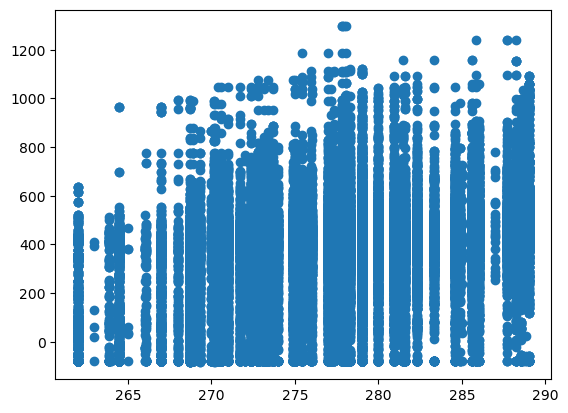

In [31]:
import matplotlib.pyplot as plt
plt.scatter(X,Y)
x=np.linspace(265,290,1)
y=11.26*x-2763.18
plt.plot(x,y)
plt.show()


使用边际成本定价的机组报价为出清价格估计

In [18]:
y_pred = model.predict(prices[train_length:])
y_pred = y_pred.flatten()  # 2维矩阵转为1维
y_pred[:5]

array([407.60234502, 401.74432316, 401.74432316, 391.1548221 ,
       401.74432316])

## 保存结果为submit.csv
成功后就可以提交到官网啦：http://competition.sais.com.cn/competitionDetail/532232/mySubmissions

In [19]:
sample_submit["clearing price (CNY/MWh)"] = y_pred
sample_submit.head()

,day,time,clearing price (CNY/MWh)
55392,2023/7/1,0:15,407.602345
55393,2023/7/1,0:30,401.744323
55394,2023/7/1,0:45,401.744323
55395,2023/7/1,1:00,391.154822
55396,2023/7/1,1:15,401.744323


In [20]:
sample_submit.to_csv("submit.csv", index=False)